C:\ProgramData\Anaconda3\lib\site-packages\tifffile\tifffile.py:306: UserWarning: ImportError: No module named '_tifffile'. Loading of some compressed images will be very slow. Tifffile.c can be obtained at http://www.lfd.uci.edu/~gohlke/
  "ImportError: No module named '_tifffile'. "


1
Best score: 10.0, -2.0
2
Best score: 11.0, -2.0
3
Best score: 10.0, 4.0
4
Best score: 11.0, 0.0
5
Best score: 11.0, -2.0
  MT         Score    PF  Skew   Diameter
0  1   3972.859871  10.0  -2.0  20.739853
1  2   7185.592112  11.0  -2.0  19.499722
2  3   3807.918579  10.0   4.0  19.423641
3  4   9897.848350  11.0   0.0  19.225829
4  5  13680.634608  11.0  -2.0  20.169241


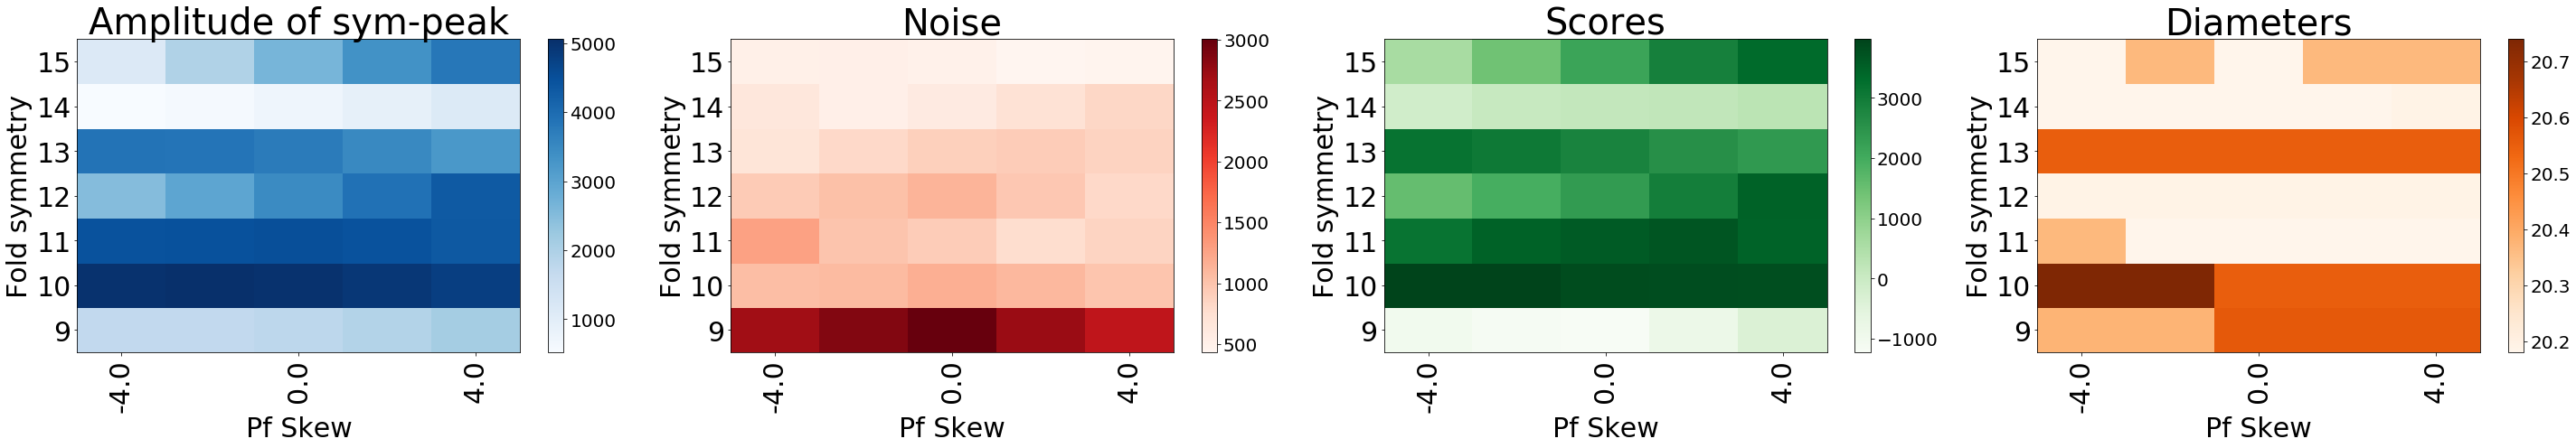

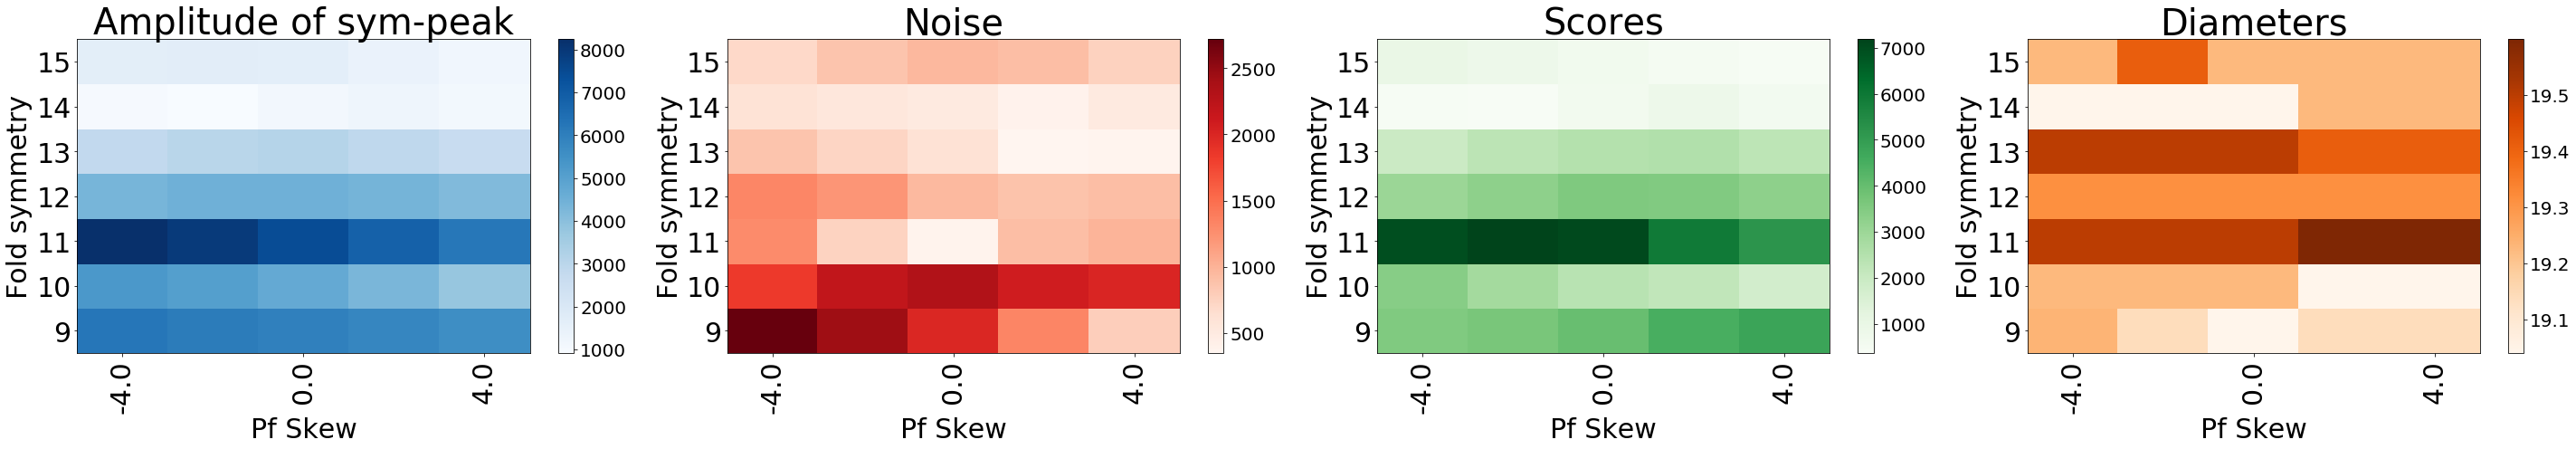

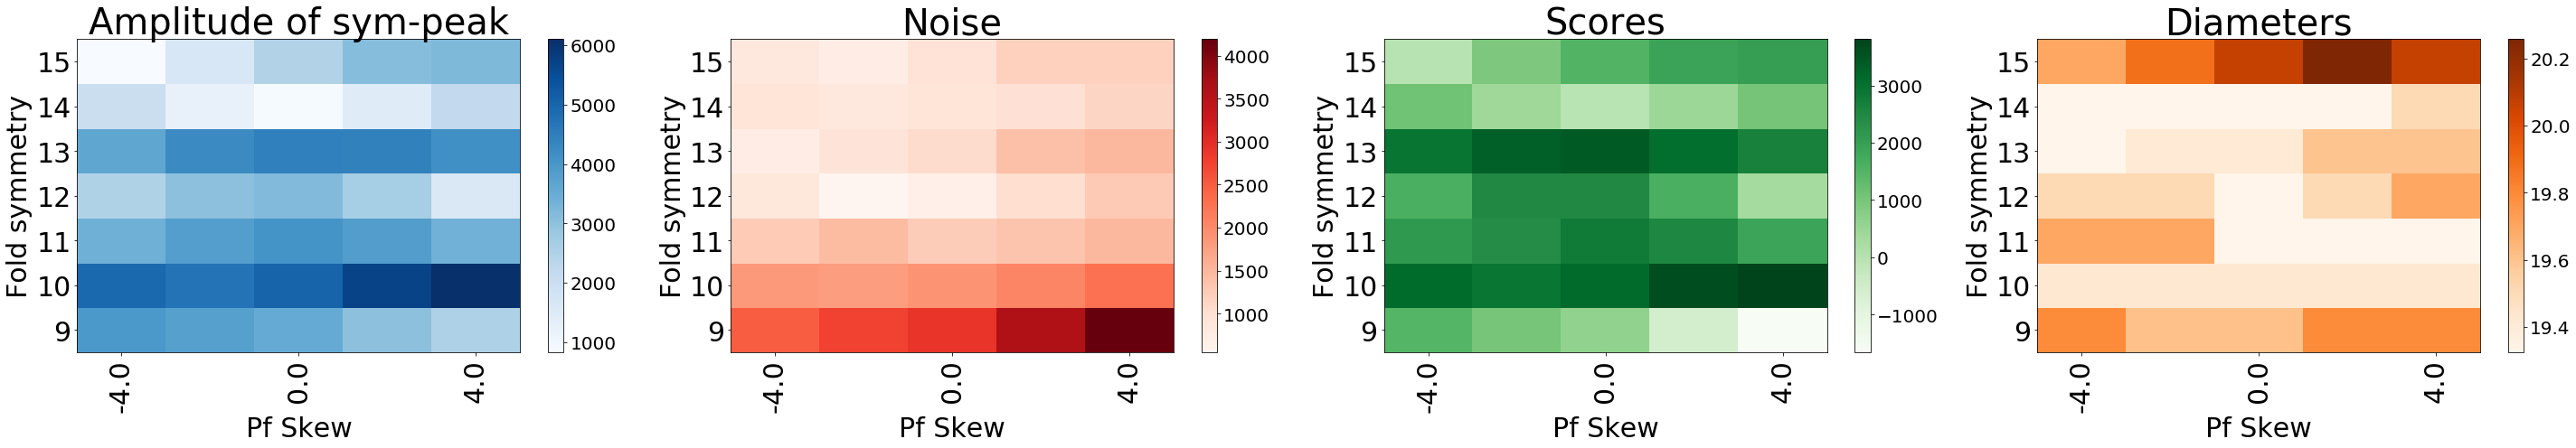

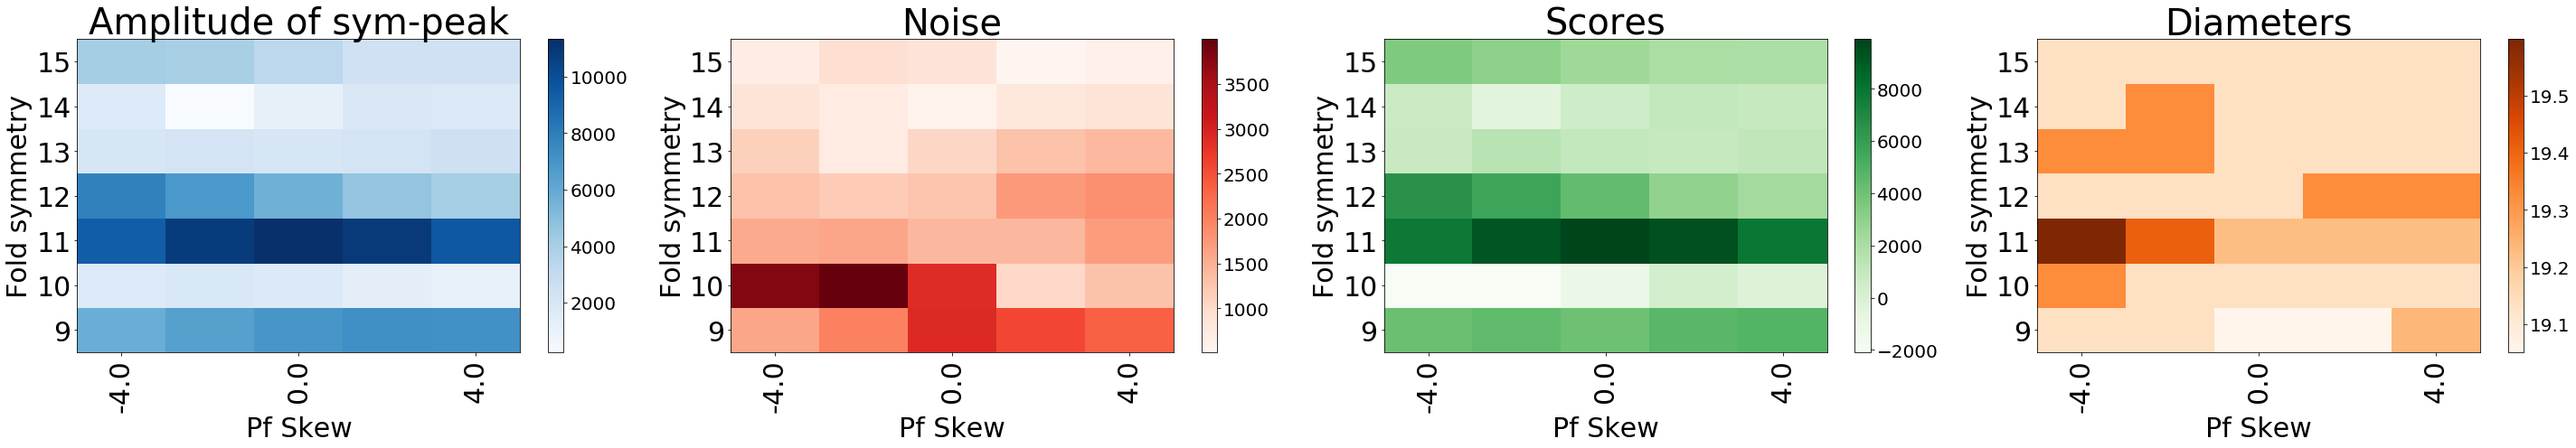

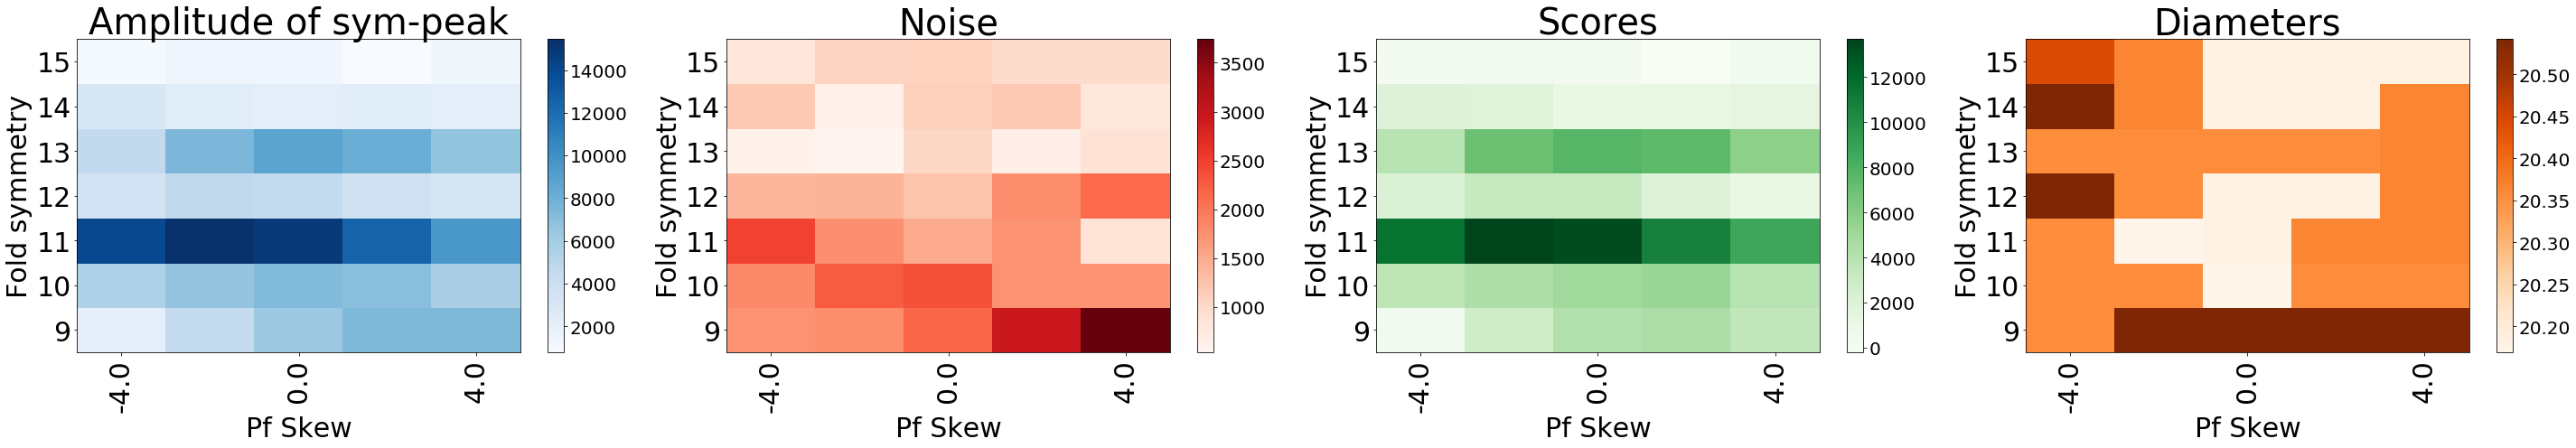

In [1]:
%matplotlib inline

import os
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import tifffile.tifffile

from skimage import color
from skimage.transform import hough_circle, hough_circle_peaks, rotate
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte
from skimage.filters import threshold_otsu
from textwrap import wrap

############################
####### PARAMETERS #########
############################

path = 'Path/To/Data/' #Path to image stack directory
writepath = 'Path/To/Data/output' #Path where the outputs from first script are located
stackname = 'cc.tif'

pixelsize_xy = 0.466/5    #there is a five pixel interpolation, units of nm/pixel
pixelsize_z = 0.466    #slice spacing, units of nm/pixel

############################
######### START! ###########
############################

#Initialize arrays for post-processing
imagenum_lst = []
numslices_lst = []
filelist = []
skew_atmax = []
fold_atmax = []
diam_atmax = []
amp_atmax = []
skew_atnoisemin = []
fold_atnoisemin = []
diam_atnoisemin = []
amp_atnoisemin = []
skew_atscrmax = []
fold_atscrmax = []
diam_atscrmax = []
amp_atscrmax = []
scr_atscrmax = []

#Smaple spacing for plot profile
spacing = 5000

plot = 1

increment = 1

for root, dirs, files in os.walk(path):
    for name in files:
        if name == stackname:
    
            filepath = os.path.join(root, name)
            im = tifffile.imread(filepath)
            
            imagenum = str(increment)
            imagenum_lst.append(imagenum)
            filelist.append(path + imagenum + '/' + stackname)
            
            stack = []

            for a in im:
                stack.append(a)

            #Convert to array and invert intensities
            stack = ~np.array(stack)

            #some simple variables
            numslices_lst.append(stack.shape[0])
            width = stack.shape[1]
            
            #IMPORT
            amplitudes_df = pd.DataFrame.from_csv(os.path.join(writepath,imagenum + "_amplitudes.csv"))
            diameters_df = pd.DataFrame.from_csv(os.path.join(writepath,imagenum + "_diameters.csv"))
            noises_df = pd.DataFrame.from_csv(os.path.join(writepath,imagenum + "_noises.csv"))
            
            amplitudes = np.transpose(pd.DataFrame.as_matrix(amplitudes_df))
            diameters = np.transpose(pd.DataFrame.as_matrix(diameters_df))
            noises = np.transpose(pd.DataFrame.as_matrix(noises_df))

            skewlist = np.array(amplitudes_df.columns).astype(np.float)
            foldslist = np.array(amplitudes_df.index).astype(np.float)
        
            scores = np.subtract(amplitudes, noises)        
            scores_df = pd.DataFrame(scores.T)
            
            #Main variables for setting search space
            maxskew = float(np.amax(np.array(amplitudes_df.columns)))

            # Plot
            if plot == 1:
                
                tickspacing = np.linspace(0.5, len(noises_df.columns)-0.5, int(len(noises_df.columns)/2+1))
                ticklabels = np.around(np.linspace(-maxskew, maxskew, int(len(noises_df.columns)/2+1)), decimals=3)
                
                fig, ax = plt.subplots(1,4, figsize=(40, 7))
                plt.subplot(1,4,1)
                plt.pcolor(amplitudes_df, cmap='Blues')
                plt.yticks(np.arange(0.5, len(amplitudes_df.index), 1), amplitudes_df.index, fontsize = 30)
                plt.xticks(tickspacing, ticklabels, fontsize = 30, rotation=90)
                plt.xlabel('Pf Skew', fontsize = 30)
                plt.ylabel('Fold symmetry', fontsize = 30)
                plt.title('Amplitude of sym-peak', fontsize = 40)
                plt.colorbar().ax.tick_params(labelsize=20) 
                plt.subplot(1,4,2)
                plt.pcolor(noises_df, cmap='Reds')
                plt.yticks(np.arange(0.5, len(diameters_df.index), 1), noises_df.index, fontsize = 30)
                plt.xticks(tickspacing, ticklabels, fontsize = 30, rotation=90)
                plt.xlabel('Pf Skew', fontsize = 30)
                plt.ylabel('Fold symmetry', fontsize = 30)
                plt.title('Noise', fontsize = 40)
                plt.colorbar().ax.tick_params(labelsize=20) 
                plt.subplot(1,4,3)
                plt.pcolor(scores_df, cmap='Greens')
                plt.yticks(np.arange(0.5, len(diameters_df.index), 1), diameters_df.index, fontsize = 30)
                plt.xticks(tickspacing, ticklabels, fontsize = 30, rotation=90)
                plt.xlabel('Pf Skew', fontsize = 30)
                plt.ylabel('Fold symmetry', fontsize = 30)
                plt.title('Scores', fontsize = 40)
                plt.colorbar().ax.tick_params(labelsize=20)  
                plt.subplot(1,4,4)
                plt.pcolor(diameters_df, cmap='Oranges')
                plt.yticks(np.arange(0.5, len(diameters_df.index), 1), diameters_df.index, fontsize = 30)
                plt.xticks(tickspacing, ticklabels, fontsize = 30, rotation=90)
                plt.xlabel('Pf Skew', fontsize = 30)
                plt.ylabel('Fold symmetry', fontsize = 30)
                plt.title('Diameters', fontsize = 40)
                plt.colorbar().ax.tick_params(labelsize=20)   
                # Save
                plt.tight_layout()
                fig.savefig(os.path.join(writepath, imagenum + "_heatmaps.pdf"))
            
            amp_atmax.append(np.amax(amplitudes))
            amp_atnoisemin.append(np.amin(noises))
            scr_atscrmax.append(np.amax(scores))
            
            # Get best skew and fold symmetry
            maximumloc = [np.where(amplitudes == np.amax(amplitudes))[0][0]], [np.where(amplitudes == np.amax(amplitudes))[1][0]]
            maximumloc = maximumloc[0][0], maximumloc[1][0]

            skew_atmax.append(np.around(skewlist[maximumloc[0]],decimals=2))
            fold_atmax.append(np.around(foldslist[maximumloc[1]],decimals=2))
            diam_atmax.append(diameters[maximumloc])
            
            noiseminloc = [np.where(noises == np.amin(noises))[0][0]], [np.where(noises == np.amin(noises))[1][0]]
            noiseminloc = noiseminloc[0][0], noiseminloc[1][0]
            
            skew_atnoisemin.append(np.around(skewlist[noiseminloc[0]],decimals=2))
            fold_atnoisemin.append(np.around(foldslist[noiseminloc[1]],decimals=2))
            diam_atnoisemin.append(diameters[noiseminloc])
            
            scrmaxloc = [np.where(scores == np.amax(scores))[0][0]], [np.where(scores == np.amax(scores))[1][0]]
            scrmaxloc = scrmaxloc[0][0], scrmaxloc[1][0]
            
            skew_atscrmax.append(np.around(skewlist[scrmaxloc[0]],decimals=2))
            fold_atscrmax.append(np.around(foldslist[scrmaxloc[1]],decimals=2))
            diam_atscrmax.append(diameters[scrmaxloc])
    
            print(increment)
            print("Best score: " + str(np.around(foldslist[scrmaxloc[1]],decimals=0)) + ", " + str(np.around(skewlist[scrmaxloc[0]],decimals=2)))

            increment += 1
            
result = pd.DataFrame({'MT': imagenum_lst, 'Score': scr_atscrmax, 'PF': fold_atscrmax, 'Skew': skew_atscrmax, 'Diameter': diam_atscrmax})
result= result[['MT','Score', 'PF', 'Skew', 'Diameter']]
result.to_csv(writepath + 'RESULT.csv')
print(result)

Done 1                     
Done 2                     
Done 3                     
Done 4                     
Done 5                     


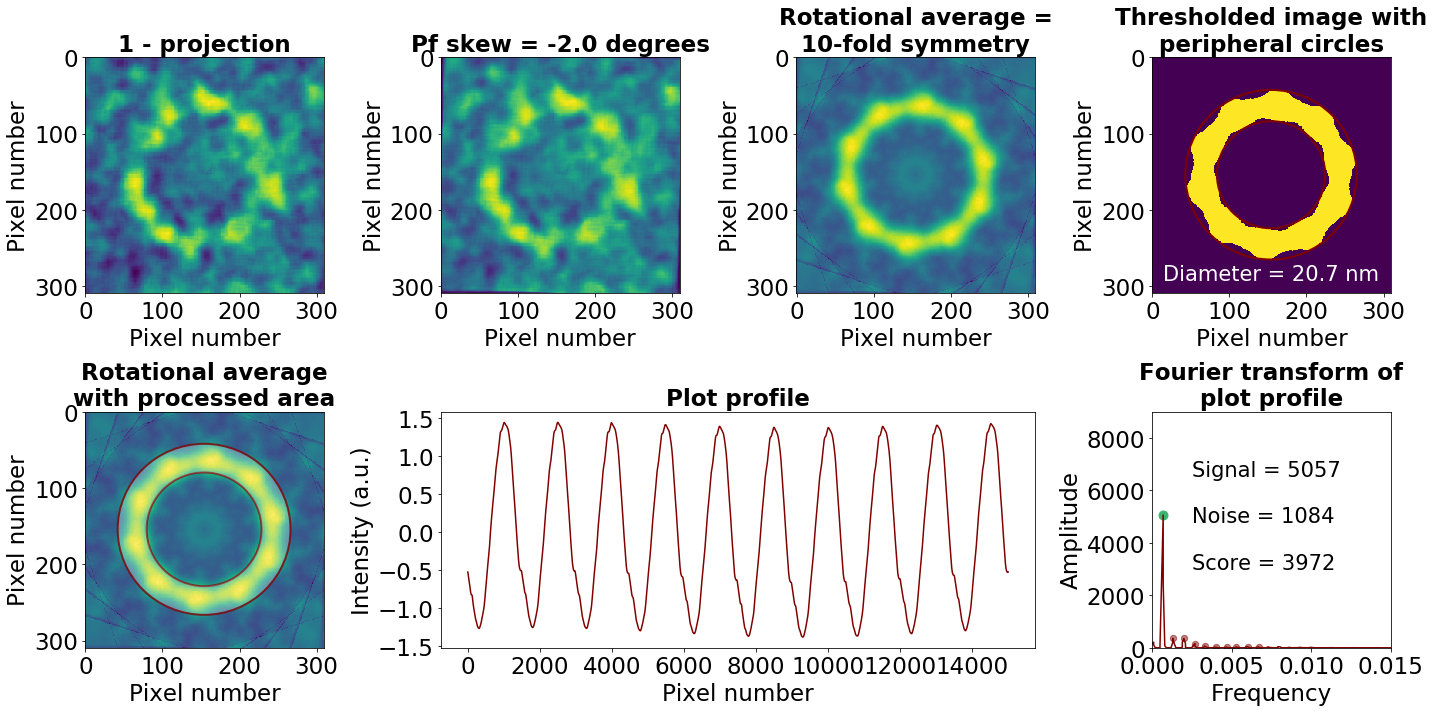

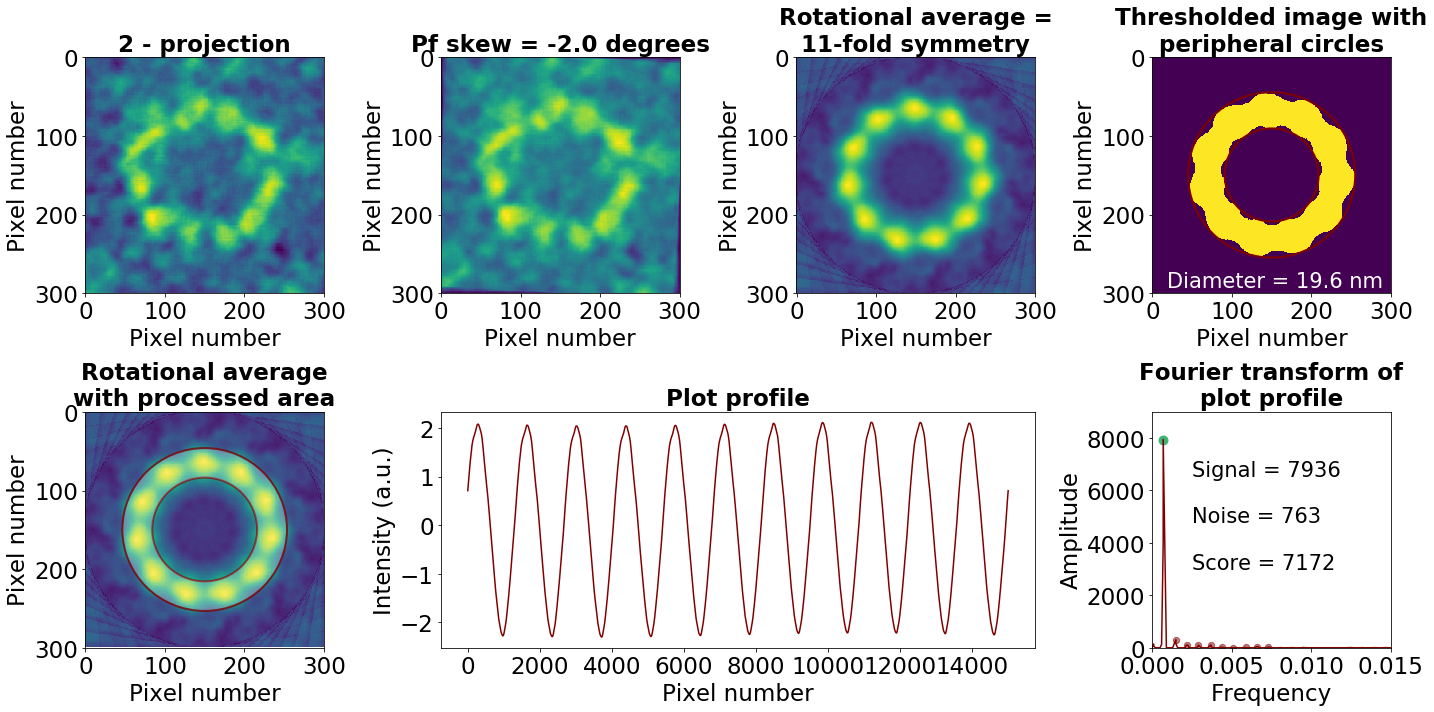

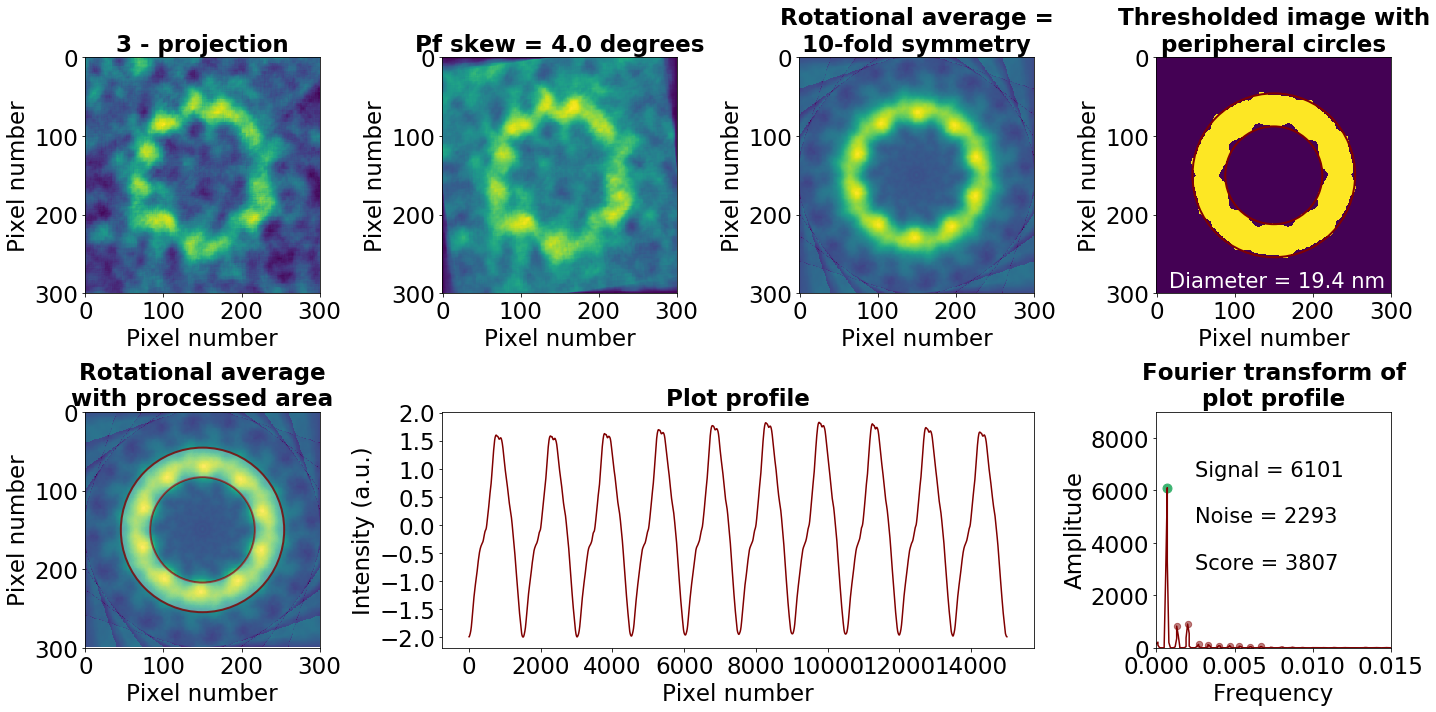

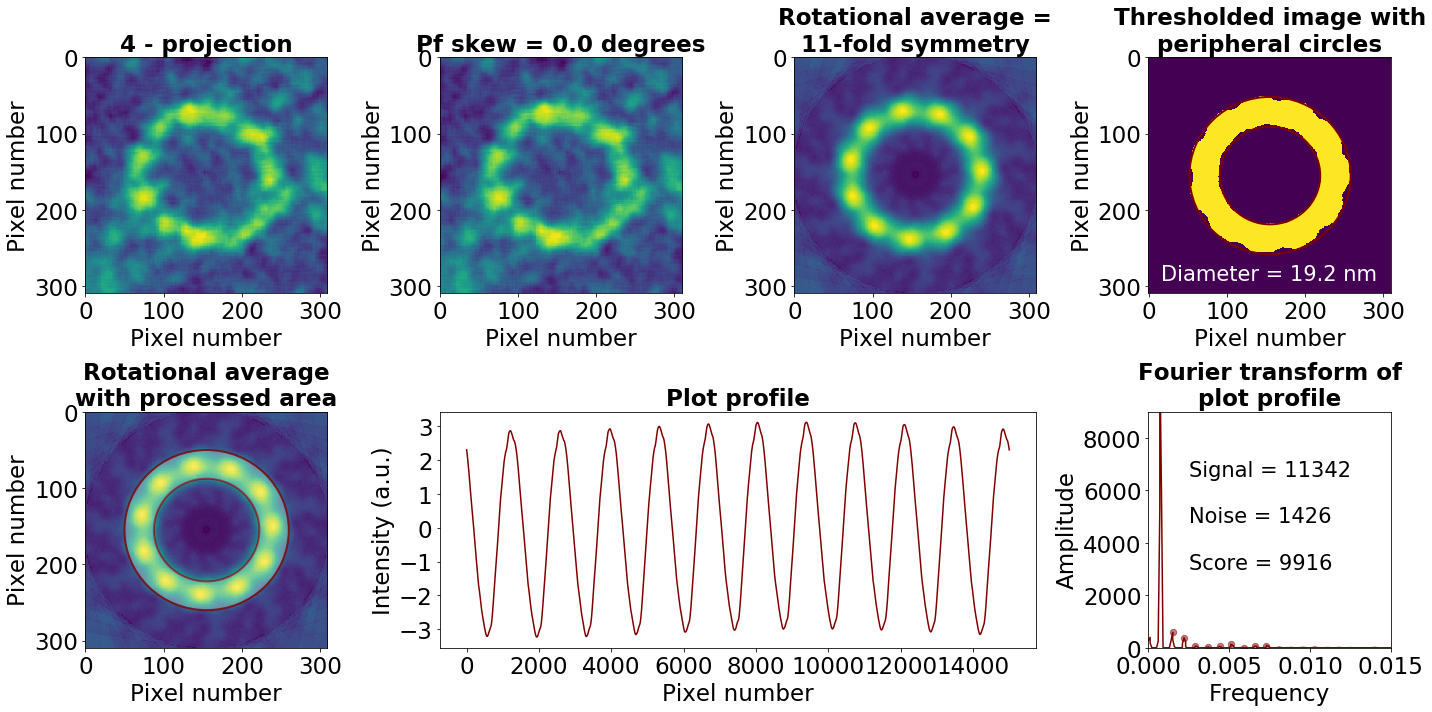

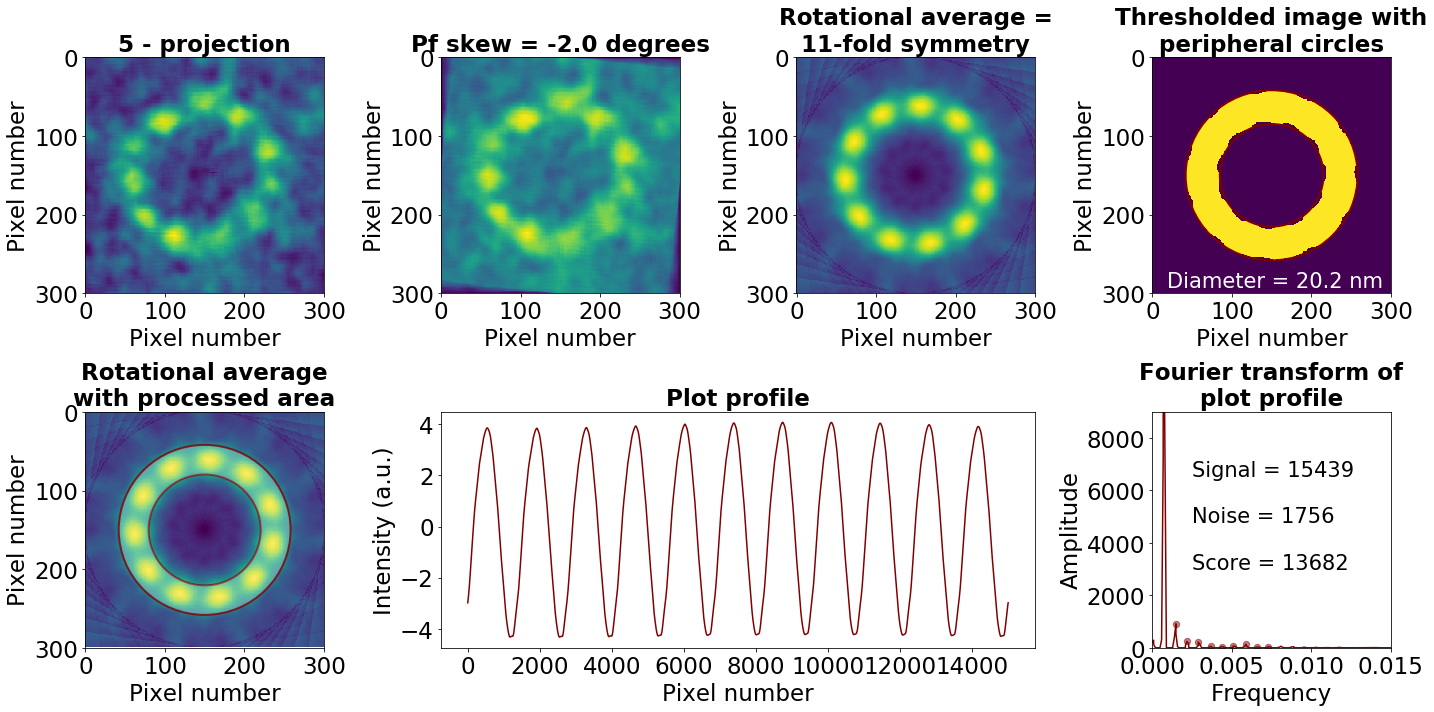

In [2]:
#SHOW THE BEST RESULT FOR EACH CASE - STEP-BY-STEP PLOTS
#ALSO RECALCULATE PLOT PROFILE AND SYMPEAK AMPLITUDE INCLUDING A NORMALIZATION STEP

#Smapling parameters
spacing = 15000
num_circles = 100

#Reset amp_atmax since here I do a normalization of the plot profile
amp_atmax = []
noises = []

#Function to convert pf skew to inter-slice rotation angle
def interslice(skew):
    return(pixelsize_z*np.degrees(np.tan(np.radians(skew)))/10)

for c, file in enumerate(filelist):
    
    print("Working on " + imagenum_lst[c], end='\r', flush=True)
    
    stack = []

    im = tifffile.imread(file)
    for a in im:
        stack.append(a)

    #Convert to array and invert intensities
    stack = ~np.array(stack)
    
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))
    font_size = 23
    
    #SHOW PROJECTION OF STACK#
    ax = plt.subplot2grid((2, 4), (0, 0), colspan=1, rowspan=1, )
    ax.imshow(np.sum(stack, axis=0), cmap="viridis", aspect='auto', interpolation='none')
    ax.set_title(imagenum_lst[c] + " - projection", fontsize = font_size, fontweight='bold')
    plt.yticks(np.arange(0, 310, 100), fontsize = font_size)
    plt.xticks(np.arange(0, 310, 100), fontsize = font_size)
    plt.xlabel('Pixel number', fontsize = font_size)
    plt.ylabel('Pixel number', fontsize = font_size)
    ax.grid(False)
    
    ##########################
    ######### SKEW ###########
    ##########################
       
    #Initialize stack to store rotated images
    skew_stack = []
    
    #Convert to inter-slice rotation
    skew = interslice(skew_atscrmax[c])
    
    #Iterate over all slices in stack and apply skew to each
    for i in range(0, numslices_lst[c], 1):
        
        #Determine how much to rotate based on skew angle and slice number
        sliceskew = i * skew
        
        #Apply skew rotation to slice
        skewed_image = rotate(stack[i], sliceskew)
        
        #Add rotated image to stack of skewed images
        skew_stack.append(skewed_image)

    #Take the projection by summing all images
    projection = np.sum(skew_stack, axis=0)
    
    #SHOW SKEW RESULT
    ax = plt.subplot2grid((2, 4), (0, 1), colspan=1, rowspan=1, )
    ax.imshow(projection, cmap="viridis", aspect='auto', interpolation='none')
    ax.set_title("\n".join(wrap("Pf skew = " + str(np.around(skew_atscrmax[c],1)) + " degrees", 22)),
        fontsize = font_size, fontweight='bold')
    plt.yticks(np.arange(0, 310, 100), fontsize = font_size)
    plt.xticks(np.arange(0, 310, 100), fontsize = font_size)
    plt.xlabel('Pixel number', fontsize = font_size)
    plt.ylabel('Pixel number', fontsize = font_size)
    ax.grid(False)
    
    ##########################
    ####### ROTATION #########
    ##########################
            
    # Compute the median to replace background values after rotation (see below)
    mf = np.mean(projection)           
            
    #Calculate angle to rotate by
    rotangle = 360/fold_atscrmax[c]

    #Initialize stack to store rotated images
    rotavg_stack = []

    #Create stack of rotations
    for i in range(0, int(fold_atscrmax[c]), 1):

        #Determine how much to rotate based on iteration nu, axis=0mber
        slice_rotangle = rotangle * i            

        #Apply rotation
        rotated_image = rotate(projection, slice_rotangle)            

        #Rotation creates dark areas where pixels are absent, change those to median value
        rotated_image[rotated_image == 0] = mf

        #Add rotated image to stack of rotated images
        rotavg_stack.append(rotated_image)

    #Compute the rotational average by taking the average of all images   
    rotavg = np.mean(rotavg_stack, axis=0)
    
    #SHOW ROTATION RESULT#
    ax = plt.subplot2grid((2, 4), (0, 2), colspan=1, rowspan=1, )
    ax.imshow(rotavg, cmap="viridis", aspect='auto', interpolation='none')
    ax.set_title("\n".join(wrap("Rotational average = " + str(int(fold_atscrmax[c])) + "-fold symmetry", 22))
        , fontsize = font_size, fontweight='bold')
    plt.yticks(np.arange(0, 310, 100), fontsize = font_size)
    plt.xticks(np.arange(0, 310, 100), fontsize = font_size)
    plt.xlabel('Pixel number', fontsize = font_size)
    plt.ylabel('Pixel number', fontsize = font_size)
    ax.grid(False)

    ##########################
    ####### THRESHOLD ########
    ##########################

    thresh = threshold_otsu(rotavg)
    binary = rotavg >+ thresh

    ##########################
    ####### HOUGH-LINE #######
    ##########################

    # Create Houg90magesum + h circle with radii between 50 and 200.
    hough_radii = np.linspace(50, 200, 50)
    hough_res = hough_circle(binary, hough_radii)

    # Select 10 circles
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=10, min_xdistance=0, min_ydistance=0)

    # Get the circle with the smallest radius
    min_circle_index = np.argmin(radii)
    min_circle_radius = radii[min_circle_index]
    min_circle_x = cx[min_circle_index]
    min_circle_y = cy[min_circle_index]

    # Get the circle with the biggest radius
    max_circle_index = np.argmax(radii)
    max_circle_radius = radii[max_circle_index]
    max_circle_x = cx[max_circle_index]
    max_circle_y = cy[max_circle_index]

    # Compute the average circle - OBSOLETE
    circle_x = (min_circle_x + max_circle_x) / 2
    circle_y = (min_circle_y + max_circle_y) / 2
    circle_radius = (min_circle_radius + max_circle_radius) / 2
    circle = np.array([circle_x, circle_y, circle_radius])


    ##########################
    ########## RADII #########
    ##########################

    #OUTER
    for i in range(60):

        new_radius = circle_radius + i

        # x = circle_x + radius * sinus(angle)
        x_points = np.array([circle_x + new_radius * np.sin(np.deg2rad(angle)) for angle in np.linspace(0, 360, spacing)])

        # y = circle_y + radius * cosinus(angle)
        y_points = np.array([circle_y + new_radius * np.cos(np.deg2rad(angle)) for angle in np.linspace(0, 360, spacing)])

        # Get the intensity profile by interpolation
        profile_bin = scipy.ndimage.map_coordinates(binary, np.vstack((x_points, y_points)))

        # Record diameter once mean falls below 0.1
        if np.mean(profile_bin) < 0.1:

            outer_radius = new_radius
            break

    truediam = outer_radius * 2 * pixelsize_xy

    #INNER
    for i in range(60):

        new_radius = circle_radius - i

        # x = circle_x + radius * sinus(angle)
        x_points = np.array([circle_x + new_radius * np.sin(np.deg2rad(angle)) for angle in np.linspace(0, 360, spacing)])

        # y = circle_y + radius * cosinus(angle)
        y_points = np.array([circle_y + new_radius * np.cos(np.deg2rad(angle)) for angle in np.linspace(0, 360, spacing)])

        # Get the intensity profile by interpolation
        profile_bin = scipy.ndimage.map_coordinates(binary, np.vstack((x_points, y_points)))

        # Record diameter once mean falls below 0.1
        if np.mean(profile_bin) < 0.1:

            inner_radius = new_radius
            break

    ##########################
    ######## PROFILE #########
    ##########################

    profiles = []

    #Create a 3nm thick line to make a series of plot profiles out of
    center_radius = (outer_radius + inner_radius)/2
    inner_prof_radius = center_radius - 1.5/pixelsize_xy 
    outer_prof_radius = center_radius + 2/pixelsize_xy 

    for radius in np.linspace(inner_prof_radius, outer_prof_radius, num_circles):

        # x = circle_x + radius * sinus(angle)
        x_points = np.array([circle_x + radius * np.sin(np.deg2rad(angle)) for angle in np.linspace(0, 360, spacing)])

        # y = circle_y + radius * cosinus(angle)
        y_points = np.array([circle_y + radius * np.cos(np.deg2rad(angle)) for angle in np.linspace(0, 360, spacing)])

        # Get the intensity profile by interpolation
        profile = scipy.ndimage.map_coordinates(rotavg, np.vstack((x_points, y_points)))

        profiles.append(profile)

    #Take the average and normalize it
    profiles = np.array(profiles)
    profile = np.mean(profiles, axis=0)
    profile = profile - np.mean(profile)

    #SHOW LINES ON ROTATIONAL AVERAGE#
    ax = plt.subplot2grid((2, 4), (1, 0), colspan=1, rowspan=1, )
    ax.imshow(rotavg, cmap="viridis", aspect='auto', interpolation='none')
    for radius in np.linspace(inner_prof_radius, outer_prof_radius, num_circles):
        if radius == inner_prof_radius or radius == outer_prof_radius:
            circle_artist = plt.Circle((circle_x, circle_y), radius=radius, edgecolor='maroon', facecolor='none', lw=2, clip_on=False, alpha=0.8)
            ax.add_artist(circle_artist)
        else:
            circle_artist = plt.Circle((circle_x, circle_y), radius=radius, edgecolor='white', facecolor='none', lw=2, clip_on=False, alpha=0.05)
            ax.add_artist(circle_artist)                    
    ax.set_title("\n".join(wrap("Rotational average with processed area", 20)), fontsize = font_size, fontweight='bold')
    plt.yticks(np.arange(0, 310, 100), fontsize = font_size)
    plt.xticks(np.arange(0, 310, 100), fontsize = font_size)
    plt.xlabel('Pixel number', fontsize = font_size)
    plt.ylabel('Pixel number', fontsize = font_size)
    ax.grid(False)

    #SHOW PROFILE#
    ax = plt.subplot2grid((2, 4), (1, 1), colspan=2, rowspan=1, )
    ax.plot(profile, color = "Maroon")
    ax.set_title("Plot profile", fontsize = font_size, fontweight='bold')
    plt.yticks(fontsize = font_size)
    plt.xticks(fontsize = font_size)
    plt.xlabel('Pixel number', fontsize = font_size)
    plt.ylabel('Intensity (a.u.)', fontsize = font_size)
    ax.grid(False)
    ax.set_facecolor('white')

    #SHOW DIAMETER RESULT#
    ax = plt.subplot2grid((2, 4), (0, 3), colspan=1, rowspan=1, )
    ax.imshow(binary, cmap="viridis", aspect='auto', interpolation='none')
    ax.set_title("\n".join(wrap("Thresholded image with peripheral circles", 22)), fontsize = font_size, fontweight='bold')
    circle_artist = plt.Circle((circle_x, circle_y), radius=outer_radius, edgecolor='maroon', facecolor='none', lw=2, clip_on=False, alpha=1)
    ax.add_artist(circle_artist)
    circle_artist_in = plt.Circle((circle_x, circle_y), radius=inner_radius, edgecolor='maroon', facecolor='none', lw=2, clip_on=False, alpha=1)
    ax.add_artist(circle_artist_in)
    ax.text(154, 285, "Diameter = " + str(np.around(truediam,1)) + " nm", verticalalignment='center',
        horizontalalignment='center', fontsize = font_size-2, color = "white")
    plt.yticks(np.arange(0, 310, 100), fontsize = font_size)
    plt.xticks(np.arange(0, 310, 100), fontsize = font_size)
    plt.xlabel('Pixel number', fontsize = font_size)
    plt.ylabel('Pixel number', fontsize = font_size)
    ax.grid(False)

    ##########################
    ######## FOURIER #########
    ##########################

    # Compute the FFT
    ft = np.fft.rfft(profile * np.hanning(len(profile)))
    ft = np.abs(ft)
    ft = ft[:int(len(profile)/2)]

    freqs = np.fft.fftfreq(len(profile), d=1)
    freqs = np.around(freqs[0:len(ft)],4)

    amplitude_sym = []

    freq_list = range(int(fold_atscrmax[c]), int(fold_atscrmax[c])*11, int(fold_atscrmax[c]))
    [amplitude_sym.append(ft[fr]) for fr in freq_list]

    noise = np.sum(amplitude_sym[1:])
    score = np.subtract(amplitude_sym[0],noise)

    #TEST ONLY - SHOW FFT# 
    ax = plt.subplot2grid((2, 4), (1, 3), colspan=1, rowspan=1)
    ax.plot(freqs, ft, color = "Maroon")
    ax.scatter(freqs[freq_list[0]], amplitude_sym[0], color='green', s=80, facecolors='mediumseagreen', edgecolors='mediumseagreen')
    for p in range(1,len(freq_list)):
        ax.scatter(freqs[freq_list[p]], amplitude_sym[p], color='green', s=40, alpha=0.5, facecolors='maroon', edgecolors='maroon')
    ax.set_xlim(0, 0.01)
    ax.set_ylim(0, 9000)
    ax.set_title("\n".join(wrap("Fourier transform of plot profile", 22)), fontsize = font_size, fontweight='bold')
    ax.text(0.0025, 5000, "Signal = " + str(int(amplitude_sym[0])) + "\n\nNoise = " + str(int(noise))+ "\n\nScore = " + str(int(score)),
        verticalalignment='center', horizontalalignment='left', fontsize = font_size-2, color = "black")
    plt.yticks(np.arange(0, 10000, 2000), fontsize = font_size)
    plt.xticks(np.arange(0, 0.016, 0.005), fontsize = font_size)
    plt.xlabel('Frequency', fontsize = font_size)
    plt.ylabel('Amplitude', fontsize = font_size)
    ax.grid(False)
    ax.set_facecolor('white')
    #ax.axvline(linewidth=5, color="Black")
    #ax.axhline(linewidth=5, color="Black")
    plt.tight_layout()
    #fig.subplots_adjust(hspace=0.4)
    fig.savefig(os.path.join(writepath, imagenum_lst[c] + "_stepbystep.pdf"))
    
    print("Done " + imagenum_lst[c] + "                     ")
